In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Define the model parameters
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys # The dimension is divided among the heads.  Thus every head key value will be d_k/h= 8
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1


In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

Data preprocessing is done with Tensorflow because it is far more cleaner

In [4]:
from tensorflow import keras

In [ ]:
# Downloading the data

In [8]:
import gdown

url = f"https://drive.google.com/uc?id=1Lz7Xjx4iwp_OGBOpO2VnzJoiVk20YbmT"
gdown.download(url, None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Lz7Xjx4iwp_OGBOpO2VnzJoiVk20YbmT
To: /content/english-german-both.pkl
100%|██████████| 29.6M/29.6M [00:00<00:00, 95.0MB/s]


'english-german-both.pkl'

In [5]:
from pickle import load, dump, HIGHEST_PROTOCOL
from numpy.random import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64

class PrepareDataset:
    def __init__(self, **kwargs):
        super(PrepareDataset, self).__init__(**kwargs)
        self.n_sentences = 10000 # Number of sentences to include in the dataset
        self.train_split = 0.9  # Ratio of the training data split
        # self.val_split =  # Ratio of the validation data split

    # Fit a tokenizer
    def create_tokenizer(self, dataset):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(dataset)

        return tokenizer

    def find_seq_length(self, dataset):
        return max(len(seq.split()) for seq in dataset)

    def find_vocab_size(self, tokenizer, dataset):
        tokenizer.fit_on_texts(dataset)

        return len(tokenizer.word_index) + 1

    # Encode and pad the input sequences
    def encode_pad(self, dataset, tokenizer, seq_length):
        x = tokenizer.texts_to_sequences(dataset)
        x = pad_sequences(x, maxlen=seq_length, padding='post')
        x = convert_to_tensor(x, dtype=int64)

        return x
    def load_tokenizer(self, name):
        with open(name, 'rb') as handle:
            return load(handle)

    def save_tokenizer(self, tokenizer, name):
        with open(name + '_tokenizer.pkl', 'wb') as handle:
            dump(tokenizer, handle, protocol=HIGHEST_PROTOCOL)

    def __call__(self, filename, **kwargs):
        # Load a clean dataset
        clean_dataset = load(open(filename, 'rb'))

        # Reduce dataset size
        dataset = clean_dataset[:self.n_sentences, :]

        # Include start and end of string tokens
        for i in range(dataset[:, 0].size):
            dataset[i, 0] = "<START> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<START> " + dataset[i, 1] + " <EOS>"

        # Random shuffle the dataset
        shuffle(dataset)

        # Split the dataset in training, validation and test sets
        train = dataset[:int(self.n_sentences * self.train_split)]
        val = dataset[int(self.n_sentences * self.train_split):]
        # test = dataset[int(self.n_sentences * (1 - self.val_split)):]

        # Prepare tokenizer for the encoder input
        enc_tokenizer = self.create_tokenizer(dataset[:, 0])
        enc_seq_length = self.find_seq_length(dataset[:, 0])
        enc_vocab_size = self.find_vocab_size(enc_tokenizer, train[:, 0])

        # Prepare tokenizer for the decoder input
        dec_tokenizer = self.create_tokenizer(dataset[:, 1])
        dec_seq_length = self.find_seq_length(dataset[:, 1])
        dec_vocab_size = self.find_vocab_size(dec_tokenizer, train[:, 1])

        # Encode and pad the training input
        trainX = self.encode_pad(train[:, 0], enc_tokenizer, enc_seq_length)
        trainY = self.encode_pad(train[:, 1], dec_tokenizer, dec_seq_length)

        # Encode and pad the validation input
        valX = self.encode_pad(val[:, 0], enc_tokenizer, enc_seq_length)
        valY = self.encode_pad(val[:, 1], dec_tokenizer, dec_seq_length)

        # Save the encoder tokenizer
        self.save_tokenizer(enc_tokenizer, 'enc')

        # Save the decoder tokenizer
        self.save_tokenizer(dec_tokenizer, 'dec')

        return trainX, trainY, valX, valY,  enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size

In [9]:
dataset_manipulator=PrepareDataset()
trainX, trainY,valX, valY, enc_seq_len, dec_seq_len, enc_vocab_size, dec_vocab_size = dataset_manipulator('english-german-both.pkl')
trainX = torch.tensor(trainX.numpy())  # Convert to PyTorch tensor
trainY = torch.tensor(trainY.numpy())  # Convert to PyTorch tensor

valX = torch.tensor(valX.numpy())      # Convert to PyTorch tensor
valY = torch.tensor(valY.numpy())      # Convert to PyTorch tensor

train_dataloader= torch.utils.data.DataLoader(torch.utils.data.TensorDataset(trainX ,trainY), batch_size=batch_size, shuffle=True)
val_dataloader= torch.utils.data.DataLoader(torch.utils.data.TensorDataset(valX, valY), batch_size=batch_size, shuffle=True)

# Model

## MHA:

 It contains 1) Creation of Q,K,V. 2) subsequent division into n_heads by cutting up dimensionality of model 3) self attention in each head. 4) Then combining the heads back 5) convertion of the model into dimensionality of the model using linear layer.

In [18]:
class MultiHeadAttention(nn.Module):
  def __init__(self, h, d_k,d_v,d_model):
    super().__init__()
    self.heads= h
    self.d_k = d_k # dimensionality of k,q
    self.d_v = d_v # dimensionality of Values
    self.d_model = d_model # Model dimension ( 512)
    self.W_q  = nn.Linear(d_model, d_k) #
    self.W_k  = nn.Linear(d_model, d_k)
    self.W_v  = nn.Linear(d_model, d_v)
    self.W_o  = nn.Linear(d_v, d_model)
    # Mask matrix. We make it untrainable. Register buffer will save this matrix too during torch.save()
    # self.register_buffer('tril', torch.tril(torch.ones(max_length, max_length)))

  def forward(self, queries, keys, values,mask=None):
    #1
    q= self.W_q(queries)
    k= self.W_k(keys)
    v= self.W_v(values)
    #2
    q= self.reshape_tensor(q)
    k= self.reshape_tensor(k)
    v= self.reshape_tensor(v)
    #3
    wei = self.attention(q,k,v,self.d_k,mask)
    #4
    wei = self.reshape_tensor(wei,reverse=True)
    #5
    return self.W_o(wei)
  # We are transforming the linearly transformed into mutli heads. so that you end up with b,h,t,head//2. So you have transpose. not change the dimensionality of matrix.
  # We have done for every batch h heads by cuttting up the embed dimension not the time dimension.
  def reshape_tensor(self,x,reverse=False):
    if not reverse:
      b,t,c = x.size()
      return x.view(b,t,self.heads,c//self.heads).transpose(1,2)
    else:
      x= x.transpose(1,2)
      return x.contiguous().view(x.shape[0],x.shape[1],self.d_v)
# Attention mechanism
  def attention(self, q,k,v,d_k,mask=None):
    wei = q @ k.transpose(-2,-1) * d_k**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
    if mask is not None:
      wei += -1e9 *mask
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    return wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

### Encoder

#### FFNN

I am going to implement the layernorm and FFNN layer. Layernorm is applied at the end of each sublayer.  FFNN is applied at the end of each encoder and decoder block. FFNN layer is composed of two linear opeartions. It maps to d_ff dim then takes it back. It has a ReLu layer inbetween, not after.

In [19]:
class Feed_Forward(nn.Module):
  def __init__(self, d_model, d_ff):
    super().__init__()
    self.net = nn.Sequential(
    nn.Linear(d_model, 4 * d_model),
    nn.ReLU(),
    nn.Linear(4 * d_model,d_model),
    )
  def forward(self,x):
    return self.net(x)
class layernorm(nn.Module):
  def __init__(self,d_model):
    super().__init__()
    self.ln=nn.LayerNorm(d_model) # d_model dim is consisten through layers. It fascialltes residual connection as given in forward
  def forward(self,x): # Takes in as output the residual connection as well the output of the sublayer.( attention or FFNN) # This is no longer valid for Pre-LN Transformer
    return self.ln(x)

#### Encoder Block

We also introduce a padding mask, which sets all padded tokens to -infinity. This is similar ot look ahead mask introduced in MHA

In [20]:
class PositionalEncoding(nn.Module):
  def __init__(self, model_dimension,expected_max_sequence_length):
      super().__init__()
      position_id = torch.arange(0, expected_max_sequence_length).unsqueeze(1)
      frequencies = torch.pow(10000., -torch.arange(0, model_dimension, 2, dtype=torch.float) / model_dimension)

      positional_encodings_table = torch.zeros(expected_max_sequence_length, model_dimension)
      positional_encodings_table[:, 0::2] = torch.sin(position_id * frequencies)  # sine on even positions
      positional_encodings_table[:, 1::2] = torch.cos(position_id * frequencies)  # cosine on odd positions
      self.register_buffer('positional_encodings_table', positional_encodings_table)

  def forward(self, embeddings_batch):
      assert embeddings_batch.ndim == 3 and embeddings_batch.shape[-1] == self.positional_encodings_table.shape[1], \
          f'Expected (batch size, max token sequence length, model dimension) got {embeddings_batch.shape}'

      positional_encodings = self.positional_encodings_table[:embeddings_batch.shape[1]]
      return  positional_encodings



In [21]:
class EncoderBlock(nn.Module):
  def __init__(self,h,d_k,d_v,d_model,rate):
    super().__init__()
    self.MHA = MultiHeadAttention(h,d_k,d_v,d_model)
    self.dropout1= nn.Dropout(rate)
    self.layernorm1= layernorm(d_model)
    self.Feed_Forward= Feed_Forward(d_model,d_ff)
    self.layernorm2= layernorm(d_model)
    self.dropout2 = nn.Dropout(rate)
  def forward(self,x,padding_mask=None):
    x_sideline= self.layernorm1(x)
    x = x+ self.dropout1(self.MHA(x_sideline,x_sideline,x_sideline,padding_mask))
    x_sideline1= self.layernorm2(x) # mha->dropout-> residual -> layer
    x = x+ self.dropout2(self.Feed_Forward(x_sideline1))  #FFNN->dropout-> residual -> layer
    return x

Add a dropout layer after positionalencoding.

In [22]:
class Encoder(nn.Module):
  def __init__(self,vocab_size,max_length,d_model,h,d_k,d_v,d_ff, n_layers,rate):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_length)
    self.dropout = nn.Dropout(rate)
    self.layers = nn.ModuleList([EncoderBlock(h,d_k,d_v,d_model,rate) for _ in range(n_layers)])

  def forward(self,sentence, padding_mask):
    x = self.embedding(sentence)
    x = x + self.positional_encoding(x)
    x = self.dropout(x)
    for layer in self.layers:
      x = layer(x, padding_mask)
    return x

## Decoder

So, the structure goes as below.
 MHA -> dropout-> residual norm
 MHA2(Cross attention) -> dropout -> residual norm
 FF -> dropout -> residual norm.

In [23]:
class DecoderBlock(nn.Module):
  def __init__(self,h,d_k,d_v,d_model,d_ff,rate):
    super().__init__()
    self.MHA = MultiHeadAttention(h,d_k,d_v,d_model)
    self.dropout1= nn.Dropout(rate)
    self.add_norm = layernorm(d_model)
    self.MHA2 = MultiHeadAttention(h,d_k,d_v,d_model)
    self.dropout2= nn.Dropout(rate)
    self.add_norm2 = layernorm(d_model)
    self.Feed_Forward= Feed_Forward(d_model,d_ff)
    self.dropout3= nn.Dropout(rate)
    self.add_norm3 = layernorm(d_model)

  def forward(self,x,encoder_output,padding_mask=None,look_ahead_mask=None):
    x_sideline= self.add_norm(x)
    x = x+ self.dropout1(self.MHA(x_sideline,x_sideline,x_sideline,look_ahead_mask))
    x_sideline1= self.add_norm2(x)
    x = x+ self.dropout2(self.MHA2(x_sideline1,encoder_output,encoder_output,padding_mask)) # Enocoder output because cross attention. Padding mask because keys and values are from encoder. We do not use look_ahead_mask.
    x_sideline2= self.add_norm3(x)
    x = x+ self.dropout3(self.Feed_Forward(x_sideline2))
    return x

In [24]:
class Decoder(nn.Module):
  def __init__(self,vocab_size,max_length, d_model,h,d_k,d_v,d_ff,n_layers,rate):
    super().__init__()
    self.embedding= nn.Embedding(vocab_size,d_model)
    self.positional_encoding = PositionalEncoding(d_model, max_length)
    self.dropout = nn.Dropout(rate)
    self.layers = nn.ModuleList([DecoderBlock(h,d_k,d_v,d_model,d_ff,rate) for _ in range(n_layers)])
  def forward(self,decoder_input,encoder_output,lookahead_mask,padding_mask):
    x = self.embedding(decoder_input)
    x = x + self.positional_encoding(x)
    x = self.dropout(x)
    for layer in self.layers:
      x = layer(x,encoder_output,padding_mask,lookahead_mask)
    return x

## Transformer

In [25]:
class Transformer(nn.Module):
  def __init__(self,enc_vocab_size,dec_vocab_size,enc_seq_len,dec_seq_len,d_model,h,d_k,d_v,d_ff,n_layers,rate):
    super().__init__()
    self.encoder = Encoder(enc_vocab_size,enc_seq_len,d_model,h,d_k,d_v,d_ff, n_layers,rate)
    self.decoder = Decoder(dec_vocab_size,dec_seq_len,d_model,h,d_k,d_v,d_ff,n_layers,rate)
    self.model_output = nn.Linear(d_model,dec_vocab_size) #converting d_model to dec_vocab_size)
    self.init_weights()
  def init_weights(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)
  def forward(self,encoder_input,decoder_input):
    padding_mask_enc   = self.padding_mask(encoder_input)
    padding_mask_dec   = self.padding_mask(decoder_input)
    lookahead_mask_dec = self.look_ahead_mask(decoder_input.shape[1])
    lookahead_mask_dec = torch.maximum(lookahead_mask_dec,padding_mask_dec) # important. Here we are using look_ahead_mask and padding_mask. Padding Mask is in relation with the decoder input. not the encoder input.
    encoder_output     = self.encoder(encoder_input,padding_mask_enc)
    decoder_output     = self.decoder(decoder_input,encoder_output,lookahead_mask_dec,padding_mask_enc)
    return self.model_output(decoder_output)
  def padding_mask(self,x): # Changes the values to 1 from 0. Where zero is pad vocab
    x=(x==0).float()
    x=x.type(torch.float32)
    return x[:,None,None,:]

  def look_ahead_mask(self,shape):
    x=torch.triu(torch.ones((shape,shape)),diagonal=1)
    return x.type(torch.float32)

# Training

## Functions

In [26]:
import torch
import torch.nn.functional as F
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def loss_fcn(target, prediction):
  padding_mask = (target != 0).float()
  loss = F.cross_entropy(prediction, target, reduction='none',label_smoothing=0.1) * padding_mask # reduction none returns values every seq length. Otherwise will return a mean scalar.
  # Compute the mean loss over the unmasked values
  return loss.sum() / padding_mask.sum()

def accuracy_fcn(target, prediction):
    padding_mask = (target != 0)
    accuracy = (target == torch.argmax(prediction, dim=2))
    accuracy = padding_mask & accuracy # And operation. If padding mask is 0 ( padded accuracy is not counted)
    padding_mask = padding_mask.float()
    accuracy = accuracy.float()
    # Compute the mean accuracy over the unmasked values
    return accuracy.sum() / padding_mask.sum()

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def BLEU(reference, candidate, pad_token=0):
    # Smoothing function (using method6)
    smooth_fn = SmoothingFunction().method4
    eos = dec_tokenizer.word_index['eos']

    # Remove padding and <eos> tokens from reference and candidate sequences
    candidate = [[word for word in sent if word not in [pad_token, eos]] for sent in candidate]
    reference = [[word for word in sent if word not in [pad_token, eos]] for sent in reference]

    bleu_score = 0
    bleu_scores = []  # Store individual BLEU scores for debugging

    # Compute BLEU score for each sentence in the batch
    for cand, ref in zip(candidate, reference):
      for i in range(len(cand)):
        cand[i] = cand[i].item()
      for i in range(len(ref)):
        ref[i] = ref[i].item()
      score = sentence_bleu([ref],cand, smoothing_function=smooth_fn)
      bleu_scores.append(score)
      bleu_score += score

    # Return average BLEU score over all sentences in the batch
    return bleu_score / len(candidate)



In [27]:
import torch
from torch.optim.lr_scheduler import _LRScheduler
import math

class LRScheduler(_LRScheduler):
  def __init__(self, optimizer, d_model, warmup_steps=150, last_epoch=-1):
    self.d_model = d_model
    self.warmup_steps = warmup_steps
    super(LRScheduler, self).__init__(optimizer, last_epoch)

  def get_lr(self):
  # Get the current step number
    step_num = max(1, self._step_count)

    # Linearly increasing the learning rate for the first warmup_steps, and decreasing it thereafter
    arg1 = step_num ** -0.5
    arg2 = step_num * (self.warmup_steps ** -1.5)

    # Compute the learning rate according to the schedule
    lr = (self.d_model ** -0.5) * min(arg1, arg2)

    return [lr for _ in self.optimizer.param_groups]

class NoWarmupLRScheduler(_LRScheduler):
    def __init__(self, optimizer, initial_lr=5e-4, decay_epoch=8, decay_factor=0.1, last_epoch=-1):
        self.initial_lr = initial_lr
        self.decay_epoch = decay_epoch
        self.decay_factor = decay_factor
        super(NoWarmupLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # Get the current epoch
        epoch = self.last_epoch + 1

        # If we are past the decay_epoch, apply the decay factor
        if epoch >= self.decay_epoch:
            lr = self.initial_lr * (self.decay_factor ** (epoch - self.decay_epoch + 1))
        else:
            lr = self.initial_lr

        # Return the updated learning rates for all parameter groups
        return [lr for _ in self.optimizer.param_groups]


In [39]:
import matplotlib.pyplot as plt
import torch

class Model_worker:
  def __init__(self, model, scheduler, optimizer, loss_fn, accuracy_fn, device, dec_vocab_size):
    self.model = model
    self.scheduler = scheduler(optimizer)
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.accuracy_fn = accuracy_fn
    self.device = device
    self.dec_vocab_size = dec_vocab_size
    self.epochs_done = 0

  def train_epoch(self, train_dataloader, BLEU):
    self.model.train()
    loss_list = []
    bleu_list = []

    for step, (i, j) in enumerate(train_dataloader):
      i, j = i.to(self.device), j.to(self.device)
      dec_input = j[:, :-1]
      target = j[:, 1:]

      # Forward pass
      prediction = self.model(i, dec_input)
      loss = self.loss_fn(target.reshape(-1), prediction.reshape(-1, self.dec_vocab_size))
      accuracy = self.accuracy_fn(target, prediction)

      # Backpropagation and optimization
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      # Store loss and BLEU score
      loss_list.append(loss.item())
      bleu_list.append(BLEU(target, prediction.argmax(dim=-1)))

      # Print every 10 steps
      print( f"\rEpoch: {self.epochs_done+1} | Step {step} | Average Loss: {sum(loss_list) / len(loss_list):.5f} Average BLEU Score: {sum(bleu_list) / len(bleu_list):.5f}",end="")

    # Plot training loss
    if PLOT:
      plt.plot(loss_list)
      plt.xlabel('batch')
      plt.ylabel('Loss')
      plt.title('Loss vs batch')
      plt.show()

    self.scheduler.step()
    self.epochs_done += 1
    return sum(loss_list) / len(loss_list), sum(bleu_list) / len(bleu_list)

  def validate(self, val_dataloader, BLEU):
    self.model.eval()
    val_loss_list = []
    val_bleu_list = []

    with torch.no_grad():
      for i, j in val_dataloader:
        i, j = i.to(self.device), j.to(self.device)
        dec_input = j[:, :-1]
        target = j[:, 1:]

        # Forward pass
        prediction = self.model(i, dec_input)

        # Calculate validation loss and BLEU score
        val_loss = self.loss_fn(target.reshape(-1), prediction.reshape(-1, self.dec_vocab_size))
        val_bleu = BLEU(target, prediction.argmax(dim=-1))

        val_loss_list.append(val_loss.item())
        val_bleu_list.append(val_bleu)

    return sum(val_loss_list) / len(val_loss_list), sum(val_bleu_list) / len(val_bleu_list)

  def train_and_validate(self, train_dataloader, val_dataloader, BLEU, num_epochs):
    lossi = []
    bleui = []

    val_loss, val_bleu = self.validate(val_dataloader, BLEU)
    print(f"Validation Loss before training: {val_loss:.5f}")

    for epoch in range(num_epochs):
      # print(f"Epoch {epoch}")
      # Training
      avg_loss, avg_bleu = self.train_epoch(train_dataloader, BLEU)

      lossi.append(avg_loss)
      bleui.append(avg_bleu)

      # print(f"Epoch {epoch} | Average Loss: {avg_loss}")
      # print(f"Epoch {epoch} | Average BLEU Score: {avg_bleu}")

      # Validation
      val_loss, val_bleu = self.validate(val_dataloader, BLEU)
      print(f"\n Validation Loss: {val_loss:.5f} |  Validation BLEU Score {val_bleu:.5f}")

    return lossi, bleui

  def inference(self, eng_sentence, enc_seq_len, dec_seq_len, enc_tokenizer, dec_tokenizer,model= None):
    if model== None:
      model=self.model
    eng_tokens = enc_tokenizer.texts_to_sequences(["<START>" + eng_sentence + "<EOS>"])
    enc_input = pad_sequences(eng_tokens, maxlen=enc_seq_len, padding='post')
    enc_input = torch.tensor(enc_input).int().to(self.device)
    dec_start = torch.tensor(dec_tokenizer.texts_to_sequences(['<START>'])).to(self.device)
    dec_end = torch.tensor(dec_tokenizer.texts_to_sequences(['<EOS>'])).to(self.device)

    model.eval()
    for _ in range(dec_seq_len):
        with torch.no_grad():
            prediction = model(enc_input, dec_start)

        predicted_token = prediction[0, :].argmax(dim=-1)[-1]  # batch=1, so index first dimension

        if predicted_token == dec_end:
            break

        dec_start = torch.cat([dec_start, torch.tensor([[predicted_token]]).to(self.device)], dim=1)  # input to transformer as [Batch, time]
    model.train()

    return dec_tokenizer.sequences_to_texts(dec_start.cpu().numpy())`


## Training


In [29]:
PLOT= False # Plots loss after every epoch

In [41]:
num_epochs=15
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=Transformer(enc_vocab_size,dec_vocab_size,enc_seq_len,dec_seq_len,d_model,h,d_k,d_v,d_ff,n,dropout_rate)

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-9, betas=(0.9, 0.98), eps=1e-9)
lossi=[]
bleui=[]
model_worker = Model_worker(model, NoWarmupLRScheduler, optimizer, loss_fcn, accuracy_fcn, device, dec_vocab_size)

In [ ]:
dec_tokenizer=PrepareDataset().load_tokenizer('dec_tokenizer.pkl')
enc_tokenizer=PrepareDataset().load_tokenizer('enc_tokenizer.pkl')

### First 5 epochs

In [43]:
model_worker.train_and_validate(train_dataloader, val_dataloader, BLEU, num_epochs)

Validation Loss before training: 9.87436956167221
Epoch: 1 | Step 140 | Average Loss: 6.62536 Average BLEU Score: 0.01628
 Validation Loss: 5.226680934429169 |  Validation BLEU Score 0.030210138795995975
Epoch: 2 | Step 140 | Average Loss: 4.97868 Average BLEU Score: 0.04265
 Validation Loss: 4.714047938585281 |  Validation BLEU Score 0.05740483501090397
Epoch: 3 | Step 140 | Average Loss: 4.53276 Average BLEU Score: 0.06247
 Validation Loss: 4.3208067417144775 |  Validation BLEU Score 0.08841139398832862
Epoch: 4 | Step 140 | Average Loss: 4.16749 Average BLEU Score: 0.08415
 Validation Loss: 4.05900913476944 |  Validation BLEU Score 0.1064186562814662
Epoch: 5 | Step 44 | Average Loss: 3.85937 Average BLEU Score: 0.09817

KeyboardInterrupt: 

### Next 5 epochs

Validation Loss before training: 3.9154839515686035
Epoch 0
Step 10 | Average Loss: 3.5106863260269163
Step 10 | Average BLEU Score: 0.11851385895162177
Step 20 | Average Loss: 3.59990234375
Step 20 | Average BLEU Score: 0.11816956451879934
Step 30 | Average Loss: 3.644394779205322
Step 30 | Average BLEU Score: 0.11439369081033127
Step 40 | Average Loss: 3.5994680166244506
Step 40 | Average BLEU Score: 0.11787682211406884
Step 50 | Average Loss: 3.631153917312622
Step 50 | Average BLEU Score: 0.1146322863822313
Step 60 | Average Loss: 3.5795389890670775
Step 60 | Average BLEU Score: 0.12131983799330444
Step 70 | Average Loss: 3.53965311050415
Step 70 | Average BLEU Score: 0.12631449128198818
Step 80 | Average Loss: 3.5588732242584227
Step 80 | Average BLEU Score: 0.13127320497994663
Step 90 | Average Loss: 3.676911544799805
Step 90 | Average BLEU Score: 0.11443597318210455
Step 100 | Average Loss: 3.6259814262390138
Step 100 | Average BLEU Score: 0.11512409709426744
Step 110 | Average 

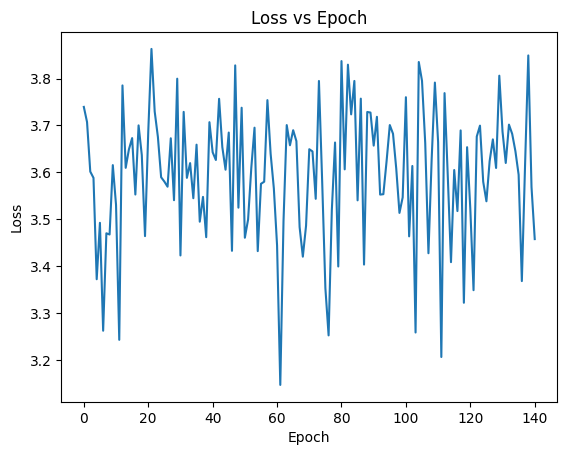

Epoch 0 | Average Loss: 3.5969779592879276
Epoch 0 | Average BLEU Score: 0.12249566151178518
Validation Loss after Epoch 0: 3.7616568207740784
Validation BLEU Score after Epoch 0: 0.13446613710904837
Epoch 1
Step 10 | Average Loss: 3.372716498374939
Step 10 | Average BLEU Score: 0.13098205985565384
Step 20 | Average Loss: 3.326780891418457
Step 20 | Average BLEU Score: 0.13359449622130104
Step 30 | Average Loss: 3.264727544784546
Step 30 | Average BLEU Score: 0.12969102301271668
Step 40 | Average Loss: 3.328478717803955
Step 40 | Average BLEU Score: 0.13531094903788957
Step 50 | Average Loss: 3.4045170545578003
Step 50 | Average BLEU Score: 0.1351770618177618
Step 60 | Average Loss: 3.2981276988983153
Step 60 | Average BLEU Score: 0.1406251749003673
Step 70 | Average Loss: 3.4232836246490477
Step 70 | Average BLEU Score: 0.13242054173320061
Step 80 | Average Loss: 3.392400860786438
Step 80 | Average BLEU Score: 0.13654291361760218
Step 90 | Average Loss: 3.291229248046875
Step 90 | Ave

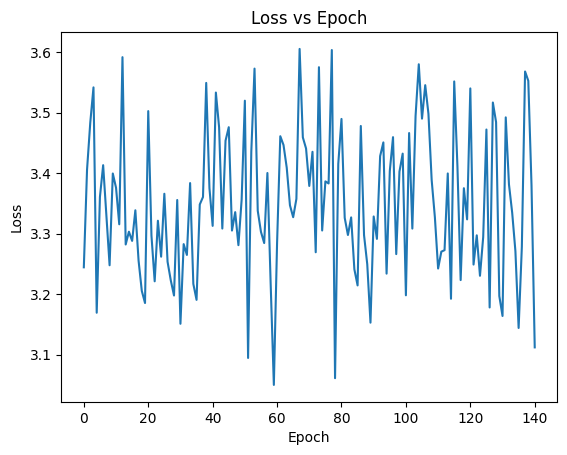

Epoch 1 | Average Loss: 3.3498673320662045
Epoch 1 | Average BLEU Score: 0.140070676236975
Validation Loss after Epoch 1: 3.6233210265636444
Validation BLEU Score after Epoch 1: 0.1557190538836989
Epoch 2
Step 10 | Average Loss: 3.0173842668533326
Step 10 | Average BLEU Score: 0.1632768531520932
Step 20 | Average Loss: 2.9457053899765016
Step 20 | Average BLEU Score: 0.17237234115468714
Step 30 | Average Loss: 2.9358766317367553
Step 30 | Average BLEU Score: 0.17524461681086348
Step 40 | Average Loss: 2.9038625955581665
Step 40 | Average BLEU Score: 0.17279305484916935
Step 50 | Average Loss: 2.8912630796432497
Step 50 | Average BLEU Score: 0.17818420336471522
Step 60 | Average Loss: 2.8445778608322145
Step 60 | Average BLEU Score: 0.18470768523626024
Step 70 | Average Loss: 2.8565539121627808
Step 70 | Average BLEU Score: 0.19523959692387644
Step 80 | Average Loss: 2.8200480461120607
Step 80 | Average BLEU Score: 0.19605192931410292
Step 90 | Average Loss: 2.861386799812317
Step 90 | 

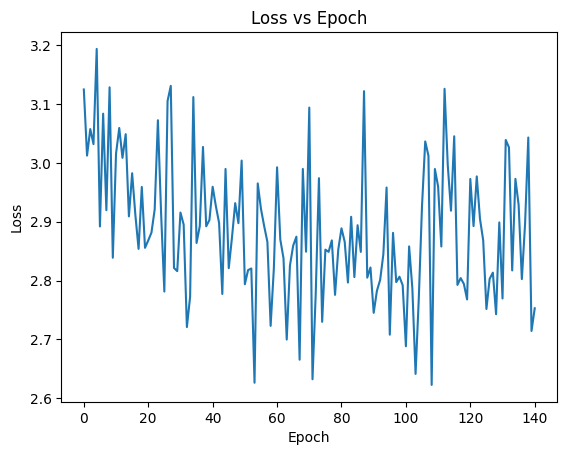

Epoch 2 | Average Loss: 2.886852409822721
Epoch 2 | Average BLEU Score: 0.18183270965621962
Validation Loss after Epoch 2: 3.490924119949341
Validation BLEU Score after Epoch 2: 0.1783056171476345
Epoch 3
Step 10 | Average Loss: 2.7155658483505247
Step 10 | Average BLEU Score: 0.20088710043501123
Step 20 | Average Loss: 2.745279812812805
Step 20 | Average BLEU Score: 0.20947662828645147
Step 30 | Average Loss: 2.7609453201293945
Step 30 | Average BLEU Score: 0.20064079402909743
Step 40 | Average Loss: 2.741284394264221
Step 40 | Average BLEU Score: 0.19555349774394065
Step 50 | Average Loss: 2.747968292236328
Step 50 | Average BLEU Score: 0.19804131008799905
Step 60 | Average Loss: 2.6644304275512694
Step 60 | Average BLEU Score: 0.207056382722403
Step 70 | Average Loss: 2.7746420383453367
Step 70 | Average BLEU Score: 0.188206588041674
Step 80 | Average Loss: 2.8437546730041503
Step 80 | Average BLEU Score: 0.1839769012988663
Step 90 | Average Loss: 2.7562490940093993
Step 90 | Averag

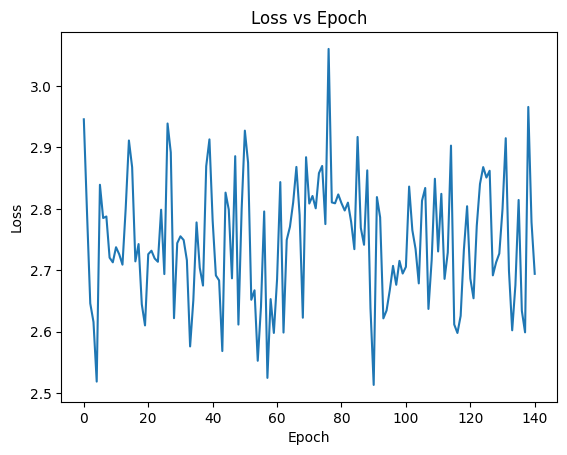

Epoch 3 | Average Loss: 2.747726381247771
Epoch 3 | Average BLEU Score: 0.19999104216197022
Validation Loss after Epoch 3: 3.4826341420412064
Validation BLEU Score after Epoch 3: 0.17895096726328494
Epoch 4
Step 10 | Average Loss: 2.7385698795318603
Step 10 | Average BLEU Score: 0.20752205957479872
Step 20 | Average Loss: 2.745586109161377
Step 20 | Average BLEU Score: 0.1999301795401309
Step 30 | Average Loss: 2.7158082723617554
Step 30 | Average BLEU Score: 0.199179677240035
Step 40 | Average Loss: 2.759230446815491
Step 40 | Average BLEU Score: 0.18778302016861154
Step 50 | Average Loss: 2.7003968477249147
Step 50 | Average BLEU Score: 0.2029199899523472
Step 60 | Average Loss: 2.741013932228088
Step 60 | Average BLEU Score: 0.19969762436838226
Step 70 | Average Loss: 2.7094414234161377
Step 70 | Average BLEU Score: 0.20254632922092197
Step 80 | Average Loss: 2.769871401786804
Step 80 | Average BLEU Score: 0.20675536203653339
Step 90 | Average Loss: 2.764850115776062
Step 90 | Avera

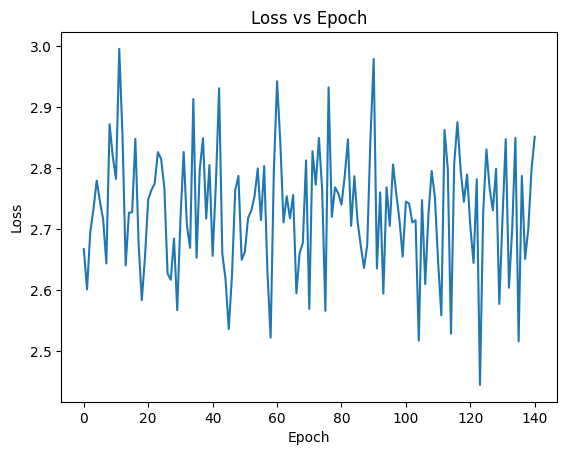

Epoch 4 | Average Loss: 2.7305289075729693
Epoch 4 | Average BLEU Score: 0.20121720410998836
Validation Loss after Epoch 4: 3.485999673604965
Validation BLEU Score after Epoch 4: 0.1774759683510965


([3.5969779592879276,
  3.3498673320662045,
  2.886852409822721,
  2.747726381247771,
  2.7305289075729693],
 [0.12249566151178518,
  0.140070676236975,
  0.18183270965621962,
  0.19999104216197022,
  0.20121720410998836])

In [ ]:
model_worker.train_and_validate(train_dataloader, val_dataloader, BLEU, num_epochs)

# Plotting

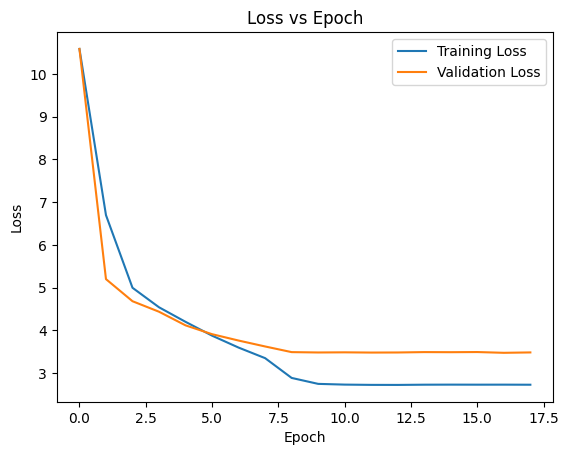

In [ ]:
plt.plot(train_Loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.plot(val_bleu, label='Validation BLEU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

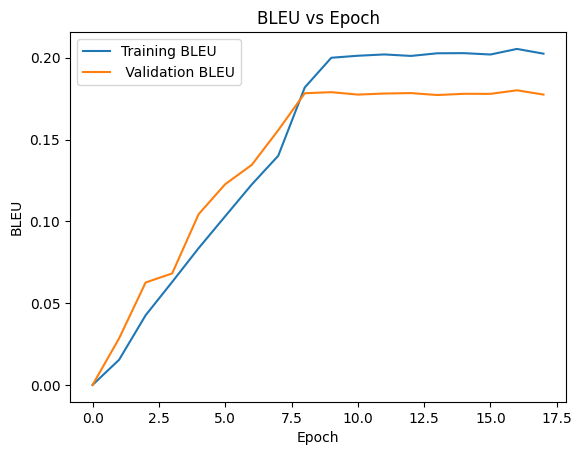

In [ ]:
plt.plot(train_BLEU, label='Training BLEU')
plt.plot(val_bleu, label=' Validation BLEU')
# plt.plot(val_bleu, label='Validation BLEU')
plt.xlabel('Epoch')
plt.ylabel('BLEU')
plt.title('BLEU vs Epoch')
plt.legend()
plt.show()

# Inference

In [ ]:
model_worker.inference('what are you doing',enc_seq_len,dec_seq_len,enc_tokenizer,dec_tokenizer)

['start was geht es gut']